# Import Libraries 

In [1]:
from math import sqrt
from numpy import concatenate
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import numpy as np
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import glob
from datetime import datetime
from keras.layers import Dropout
import numpy  as np

Using TensorFlow backend.


# Load the Data

## Loading the DataFrame and resample

In [3]:
data=pd.read_excel('Data_examplemod.xlsx',infer_datetime_format=True, index_col="Unnamed: 0")

### Resample 1hr

In [4]:
data=data.resample('1H').mean()
display(data.head(3), data.shape)

,Wind Direction (Mean) [°],Wind Speed [m/s] (Mean) [m/s],Total rain (Mean) [mm],Current Rain (Mean) [mm],Humidity (Mean) [%],Temperature (Mean) [°C],Atmospheric Pressure (Mean) [hPa],Temperature: Ambient (Mean) [°C],Temperature: Module (Mean) [°C],Radiation Power (Tilted) (Mean) [W/m²],AC Power (norm) (Mean) [kW/kWp]
2018-12-01 00:00:00,157.136668,1.7000,1793.233317,0.003333,78.713333,0.283333,1008.203328,0.2300,0.0900,0.0,0.0
2018-12-01 01:00:00,145.937496,2.0025,1793.404999,0.005000,84.445000,0.047500,1007.825012,0.0675,0.0575,0.0,0.0
2018-12-01 02:00:00,147.695000,1.8550,1793.630005,0.000000,86.740000,0.130000,1007.744995,0.1350,0.0700,0.0,0.0


(5089, 11)

### target= radiation(only) 

In [5]:
data=data.iloc[:,:10]
data.shape

(5089, 10)

# Data Preparation

### The data is converted into surperviced learning problem. we want to look the data for a week before to predict the actual week. So it is nedded to look (24*7) hours. 
https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

In [6]:
lookback_hours = 24*7
n_features = 10
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df =pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


## Data Normalization 

#### https://machinelearningmastery.com/how-to-scale-data-for-long-short-term-memory-networks-in-python/

In [7]:
values = data.values    
scaler = MinMaxScaler()
scaled = scaler.fit_transform(values)

### Transform the dataframe in a supervised problem

In [8]:
reframed=series_to_supervised(scaled,lookback_hours, n_out=1, dropnan=True)
print(reframed.shape)  

(4921, 1690)


In [9]:
reframed.columns

Index(['var1(t-168)', 'var2(t-168)', 'var3(t-168)', 'var4(t-168)',
       'var5(t-168)', 'var6(t-168)', 'var7(t-168)', 'var8(t-168)',
       'var9(t-168)', 'var10(t-168)',
       ...
       'var1(t)', 'var2(t)', 'var3(t)', 'var4(t)', 'var5(t)', 'var6(t)',
       'var7(t)', 'var8(t)', 'var9(t)', 'var10(t)'],
      dtype='object', length=1690)

## Split into train and test sets

### It was choosen 20 weeks to train, that represents 70% of the samples. 

In [10]:
values = reframed.values
weeks=20
hours_day=24
days_week=7
row_split =weeks*hours_day*days_week
train = values[:row_split, :]
test = values[row_split:, :]

In [11]:
test.shape

(1561, 1690)

#### 9 weeks

In [12]:
test=test[:1512,:]

## Spliting in X and y. 

### The fist columns that contains all the (t-i) data are using as input variables of the models, and the last column is the target , Radiation Power.

In [13]:
split_Xy=lookback_hours * n_features
train_X, train_y = train[:, :split_Xy], train[:,-1]
test_X, test_y = test[:, :split_Xy], test[:, -1]

In [14]:
print(test_X.shape, train_X.shape, train_y.shape, test_y.shape ) 


(1512, 1680) (3360, 1680) (3360,) (1512,)


## Reshape the train samples. 

### LSTM requires a 3D input [samples, n_steps, features]. In our case the samples are all the rows of the data, the n_steps is how many data Im looking to predict the actual value, and features is the columns of the data, how many types of variables Is was taken into account. 
https://machinelearningmastery.com/?s=input+LSTM&post_type=post&submit=Search
https://machinelearningmastery.com/reshape-input-data-long-short-term-memory-networks-keras/
https://medium.com/@shivajbd/understanding-input-and-output-shape-in-lstm-keras-c501ee95c65e

In [15]:
train_X = train_X.reshape((train_X.shape[0], lookback_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], lookback_hours, n_features))
print(train_X.shape, test_X.shape)

(3360, 168, 10) (1512, 168, 10)


# Neural Network

## Define the model 

### LSTM https://medium.com/mlreview/understanding-lstm-and-its-diagrams-37e2f46f1714

#### depth=1 
#### nodes=20
#### Dropout=0.5  
#### optimizer=adam 
#### loss= mse

### dropout
https://machinelearningmastery.com/how-to-reduce-overfitting-with-dropout-regularization-in-keras/
https://machinelearningmastery.com/use-dropout-lstm-networks-time-series-forecasting/

### adam 
https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/

### loss
https://machinelearningmastery.com/loss-and-loss-functions-for-training-deep-learning-neural-networks/

In [16]:
model = Sequential()
model.add(LSTM(20, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.5))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

## Training 

#### epoch=10
#### batch size=20
https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/

In [17]:
history = model.fit(train_X, train_y, epochs=10, batch_size=20, validation_data=(test_X, test_y))

Train on 3360 samples, validate on 1512 samples
Epoch 1/10
3360/3360 [==============================] - 9s 3ms/step - loss: 0.0244 - val_loss: 0.0425
Epoch 2/10
3360/3360 [==============================] - 8s 3ms/step - loss: 0.0121 - val_loss: 0.0194
Epoch 3/10
3360/3360 [==============================] - 8s 2ms/step - loss: 0.0096 - val_loss: 0.0165
Epoch 4/10
3360/3360 [==============================] - 9s 3ms/step - loss: 0.0077 - val_loss: 0.0136
Epoch 5/10
3360/3360 [==============================] - 8s 2ms/step - loss: 0.0069 - val_loss: 0.0113
Epoch 6/10
3360/3360 [==============================] - 8s 3ms/step - loss: 0.0064 - val_loss: 0.0100
Epoch 7/10
3360/3360 [==============================] - 8s 2ms/step - loss: 0.0062 - val_loss: 0.0108
Epoch 8/10
3360/3360 [==============================] - 8s 2ms/step - loss: 0.0055 - val_loss: 0.0108
Epoch 9/10
3360/3360 [==============================] - 8s 2ms/step - loss: 0.0051 - val_loss: 0.0088
Epoch 10/10
3360/3360 [===========

## Evaluation 

### Comparing loss of train and test 

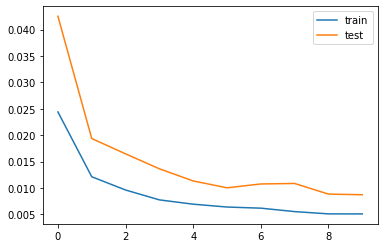

In [18]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### plot comparing predicted and test_y data

Text(0.5, 1.0, 'Radiation')

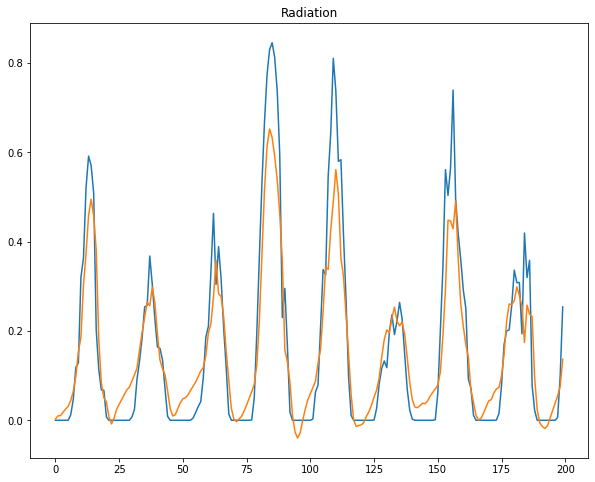

In [19]:
plt.figure(figsize=(10, 8))
pred = model.predict(test_X)
test_y=pd.DataFrame(test_y)
pred=pd.DataFrame(pred)
#plt.plot(test_y.iloc[:200,1], label='test')
#plt.plot(pred.iloc[:200,1], label='predicted')
#plt.title("AC Power")
#plt.figure()
plt.plot(test_y.iloc[:200,0])
plt.plot(pred.iloc[:200,0])
plt.title("Radiation")

## Evaluation Metrics
https://otexts.com/fpp2/accuracy.html

In [20]:
test_X=test_X.reshape(test_X.shape[0],test_X.shape[1]*test_X.shape[2])


In [21]:
# invert scaling for forecast
inv_pred = concatenate((pred, test_X[:, -9:]), axis=1)
inv_pred = scaler.inverse_transform(inv_pred)
inv_pred = inv_pred[:,0]
# invert scaling for actual
test_y = np.array(test_y).reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -9:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_pred))
print('Test RMSE: %.3f' % rmse)


Test RMSE: 29.487
